<a href="https://colab.research.google.com/github/Muhammad-Abdullah-Jami/BERT-LLM/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing important Libraries**

**Loading Libraries**

In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Device connection to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Loading Data**

In [3]:
dev_url = "https://raw.githubusercontent.com/Muhammad-Abdullah-Jami/BERT-LLM/main/dev.tsv"
test_url = "https://raw.githubusercontent.com/Muhammad-Abdullah-Jami/BERT-LLM/main/test.tsv"
train_url= "https://raw.githubusercontent.com/Muhammad-Abdullah-Jami/BERT-LLM/main/train.tsv"

dev_df=pd.read_csv(dev_url,sep='\t')
test_df=pd.read_csv(test_url,sep='\t')
train_df=pd.read_csv(train_url,sep='\t')

# Displaying the loaded data

In [4]:
dev_df

,index,sentence1,sentence2,label
0,0,The drain is clogged with hair. It has to be c...,The hair has to be cleaned.,0
1,1,Jane knocked on Susan's door but she did not a...,Susan did not answer.,1
2,2,"Beth didn't get angry with Sally, who had cut ...",Sally stopped and counted to ten.,0
3,3,No one joins Facebook to be sad and lonely. Bu...,That's exactly how Facebook makes us feel.,1
4,4,The man couldn't lift his son because he was s...,The son was so heavy.,1
...,...,...,...,...
66,66,I poured water from the bottle into the cup un...,The bottle was empty.,1
67,67,Alice looked for her friend Jade in the crowd....,"Since Alice always wears a red turban, Alice s...",0
68,68,"The dog chased the cat, which ran up a tree. I...",The cat waited at the top.,1
69,69,"It was a summer afternoon, and the dog was sit...",The spot under the tree was hot.,0


In [5]:
train_df

,index,sentence1,sentence2,label
0,0,I stuck a pin through a carrot. When I pulled ...,The carrot had a hole.,1
1,1,John couldn't see the stage with Billy in fron...,John is so short.,1
2,2,The police arrested all of the gang members. T...,The police were trying to stop the drug trade ...,1
3,3,Steve follows Fred's example in everything. He...,Steve influences him hugely.,0
4,4,"When Tatyana reached the cabin, her mother was...","mother was careful not to disturb her, undress...",0
...,...,...,...,...
630,630,"When Tommy dropped his ice cream, Timmy giggle...",Father gave Timmy a sympathetic look.,0
631,631,"Mark told Pete many lies about himself, which ...",Pete should have been more skeptical.,1
632,632,"Tom said ""Check"" to Ralph as he took his bishop.","Tom said ""Check"" to Ralph as he took Tom's bis...",0
633,633,"Emma's mother had died long ago, and her place...",Emma's mother's place had been taken by an exc...,1


In [6]:
test_df

,index,sentence1,sentence2
0,0,Maude and Dora had seen the trains rushing acr...,Horses ran away when Maude and Dora came in si...
1,1,Maude and Dora had seen the trains rushing acr...,Horses ran away when the trains came in sight.
2,2,Maude and Dora had seen the trains rushing acr...,Horses ran away when the puffs came in sight.
3,3,Maude and Dora had seen the trains rushing acr...,Horses ran away when the roars came in sight.
4,4,Maude and Dora had seen the trains rushing acr...,Horses ran away when the whistles came in sight.
...,...,...,...
141,141,Muriel has in her living room a famous paintin...,It is very characteristic of Muriel's later wo...
142,142,Muriel has in her living room a famous paintin...,It is very characteristic of Theresa Rubio's l...
143,143,Muriel has in her living room a famous paintin...,It is very characteristic of Cecile d'Arblay's...
144,144,Edward dropped adhesive tape onto his window s...,Some of the glue was stuck on the tape.


**EDA**

In [7]:
print(dev_df.info())
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      71 non-null     int64 
 1   sentence1  71 non-null     object
 2   sentence2  71 non-null     object
 3   label      71 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      635 non-null    int64 
 1   sentence1  635 non-null    object
 2   sentence2  635 non-null    object
 3   label      635 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 20.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      146 non-null    i

In [8]:
print(dev_df.isnull().sum())
print(train_df.isnull().sum())
print(test_df.isnull().sum())


index        0
sentence1    0
sentence2    0
label        0
dtype: int64
index        0
sentence1    0
sentence2    0
label        0
dtype: int64
index        0
sentence1    0
sentence2    0
dtype: int64


In [9]:
print("Train columns:", train_df.columns)
print("Development columns:", dev_df.columns)
print("Test columns:", test_df.columns)


Train columns: Index(['index', 'sentence1', 'sentence2', 'label'], dtype='object')
Development columns: Index(['index', 'sentence1', 'sentence2', 'label'], dtype='object')
Test columns: Index(['index', 'sentence1', 'sentence2'], dtype='object')


**Preprocessing**

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def preprocess_text(data):
  """
  Removing the spacing in data , lower casing the data and tokenizing the data
  """
  return tokenizer.encode_plus(
      data.lower().strip(),              #Lower casing and striping the data
      add_special_tokens=True,          # adding spertation special tokens
      max_length=512,                   #setting the max length of the data to 512
      pad_to_max_length=True,           #padding the data to max length
      truncation=True,                  #truncating the data to max lenght
      return_attention_mask=True,        # Generating the attenion marks
      return_tensors='pt'                # returning the tensors


  )
def preprocess_data(data):
  """
  Preprocessing the data by using lambda functions on the data
  """
  data['sentence1_tokens']=data['sentence1'].apply(lambda x:preprocess_text(x))
  data['sentence2_tokens']=data['sentence2'].apply(lambda x:preprocess_text(x))
  return data

#calling the functions to apply the preprocessing

dev_df=preprocess_data(dev_df)
test_df=preprocess_data(test_df)
train_df=preprocess_data(train_df)

train_df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

,index,sentence1,sentence2,label,sentence1_tokens,sentence2_tokens
0,0,I stuck a pin through a carrot. When I pulled ...,The carrot had a hole.,1,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
1,1,John couldn't see the stage with Billy in fron...,John is so short.,1,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
2,2,The police arrested all of the gang members. T...,The police were trying to stop the drug trade ...,1,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
3,3,Steve follows Fred's example in everything. He...,Steve influences him hugely.,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
4,4,"When Tatyana reached the cabin, her mother was...","mother was careful not to disturb her, undress...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


**Model Training upto 5 epochs with changed parameters to select best suited model**

In [11]:
# Data Prepration for model

def create_dataset(data, include_labels=True):
    input_ids = torch.cat(data['sentence1_tokens'].apply(lambda x: x['input_ids']).tolist(), dim=0)
    attention_masks = torch.cat(data['sentence1_tokens'].apply(lambda x: x['attention_mask']).tolist(), dim=0)
    if include_labels:
        labels = torch.tensor(data['label'].tolist())
        return TensorDataset(input_ids, attention_masks, labels)
    else:
        return TensorDataset(input_ids, attention_masks)

# Prepare the datasets
train_dataset = create_dataset(train_df)
dev_dataset = create_dataset(dev_df)
test_dataset = create_dataset(test_df, include_labels=False)

# Prepare data loaders
batch_size = 16  # You can experiment with this size later
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


In [12]:
# Initialize the BERT model for sequence classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)  # You can experiment with learning rate and eps
total_steps = len(train_dataloader) * 5  # Total number of training steps is number of batches * number of epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Lists to store performance metrics for plotting
train_loss_set = []
accuracy_set = []
f1_set = []

# Training loop
for epoch in range(5):  # Training for 5 epochs
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_set.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []

    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)
        tmp_eval_accuracy = accuracy_score(np.argmax(logits, axis=1).flatten(), label_ids.flatten())
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Validation Accuracy: {eval_accuracy/nb_eval_steps}")
    accuracy_set.append(eval_accuracy/nb_eval_steps)
    f1 = f1_score(np.concatenate(true_labels), np.concatenate(predictions, axis=0).argmax(axis=1), average='weighted')
    f1_set.append(f1)
    print(f"Validation F1 Score: {f1}")


Epoch 1, Average Training Loss: 0.7025071606040001
Validation Accuracy: 0.5392857142857143
Validation F1 Score: 0.3928156092518414
Epoch 2, Average Training Loss: 0.6992283508181572
Validation Accuracy: 0.5642857142857143
Validation F1 Score: 0.40603984265956095
Epoch 3, Average Training Loss: 0.7003952190279961
Validation Accuracy: 0.42321428571428565
Validation F1 Score: 0.2593780504811044
Epoch 4, Average Training Loss: 0.6982917100191116
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093
Epoch 5, Average Training Loss: 0.6987682580947876
Validation Accuracy: 0.5142857142857142
Validation F1 Score: 0.3790970119784125


#another experiment

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 0.6998150080442429
Validation Accuracy: 0.43661971830985913
Validation F1 Score: 0.26539629936481635


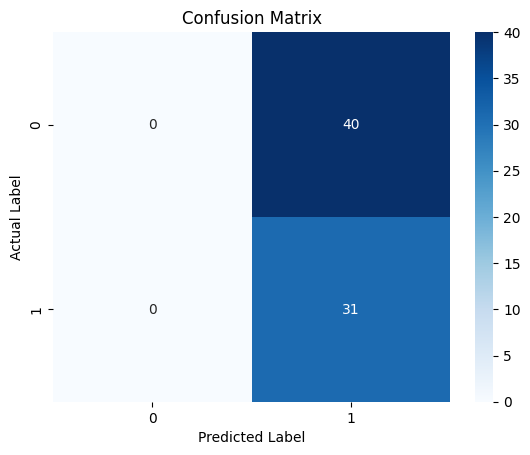

Epoch 2, Training Loss: 0.706767912209034
Validation Accuracy: 0.43661971830985913
Validation F1 Score: 0.26539629936481635


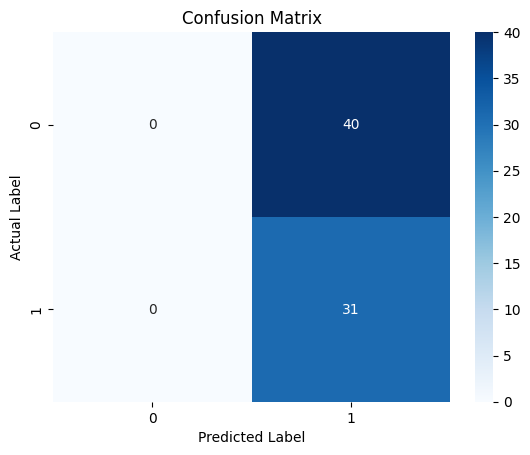

Epoch 3, Training Loss: 0.7005715787410736
Validation Accuracy: 0.323943661971831
Validation F1 Score: 0.30459524825722006


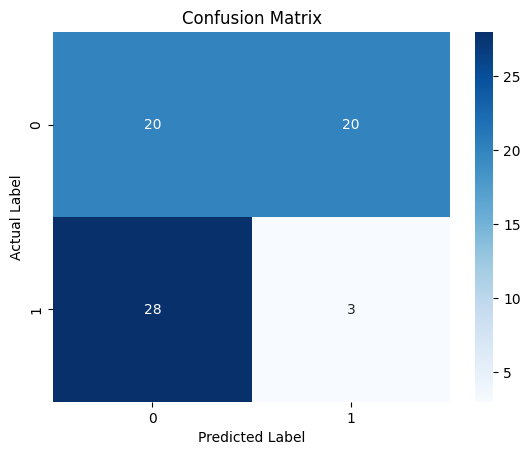

Epoch 4, Training Loss: 0.695609700679779
Validation Accuracy: 0.4084507042253521
Validation F1 Score: 0.2532394366197183


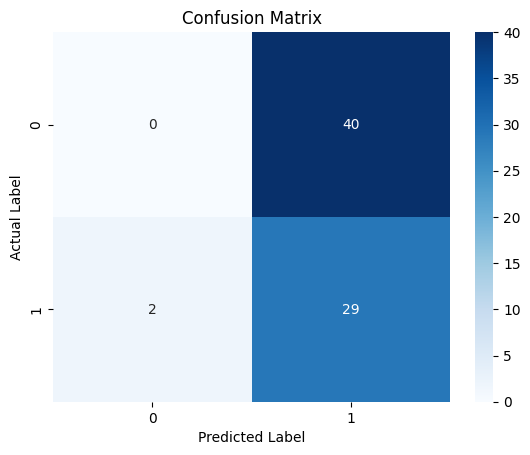

Epoch 5, Training Loss: 0.6967184647917748
Validation Accuracy: 0.5211267605633803
Validation F1 Score: 0.38601982263954093


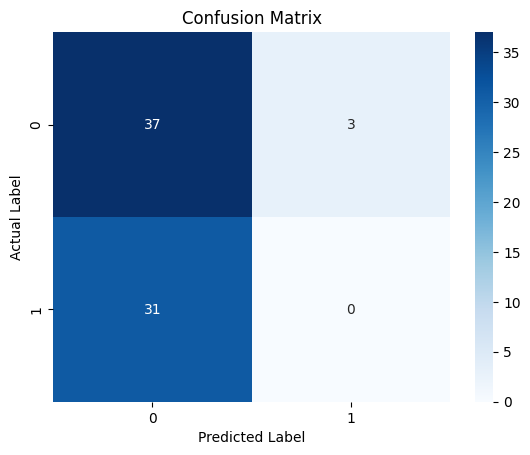

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the optimizer settings
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)  # Reduced learning rate

# Training loop
for epoch in range(5):  # More epochs can be tested here
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_dataloader)}")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Validation Accuracy: {accuracy}")
    print(f"Validation F1 Score: {f1}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


100 epochs code 1

Epoch 1, Average Training Loss: 0.7156995743513107
Validation Accuracy: 0.4732142857142857
Validation F1 Score: 0.47134406023343367


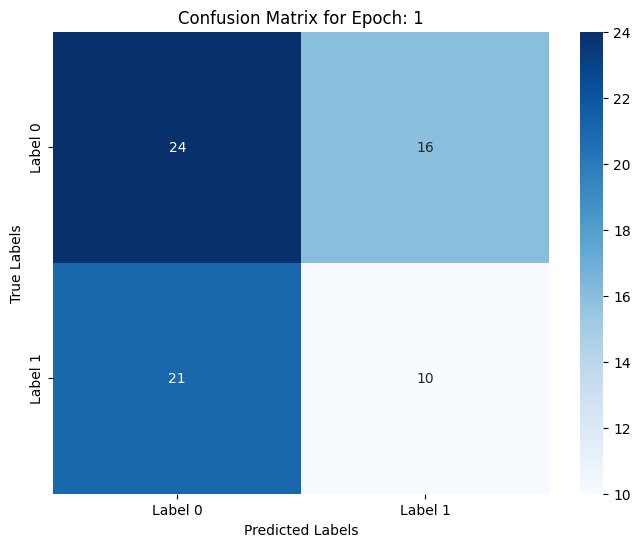

Epoch 2, Average Training Loss: 0.7014954596757889
Validation Accuracy: 0.5642857142857143
Validation F1 Score: 0.40603984265956095


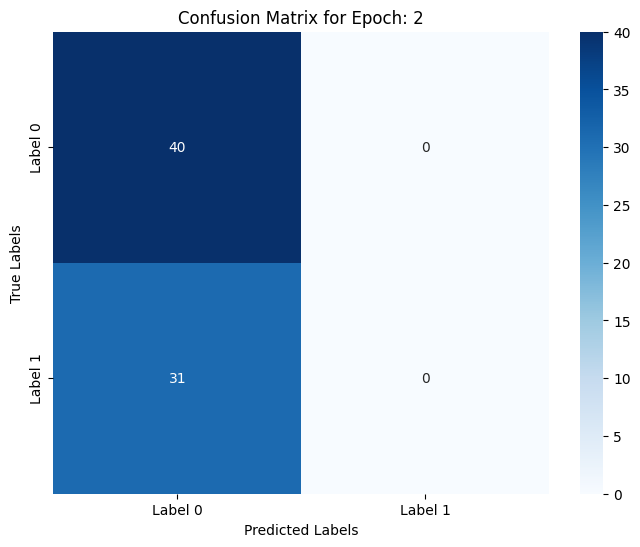

Epoch 3, Average Training Loss: 0.6955554530024528
Validation Accuracy: 0.43571428571428567
Validation F1 Score: 0.28879946344735075


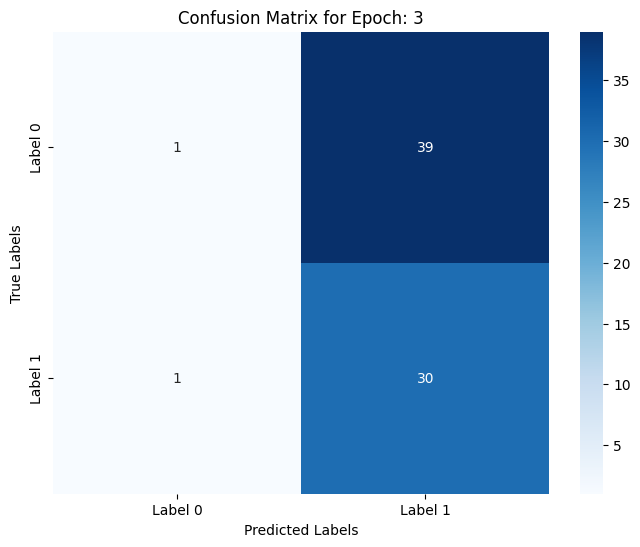

Epoch 4, Average Training Loss: 0.6943939968943595
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


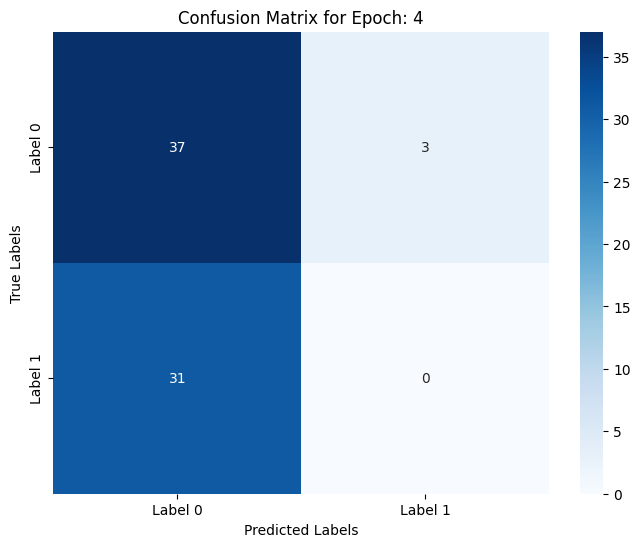

Epoch 5, Average Training Loss: 0.6913863390684127
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


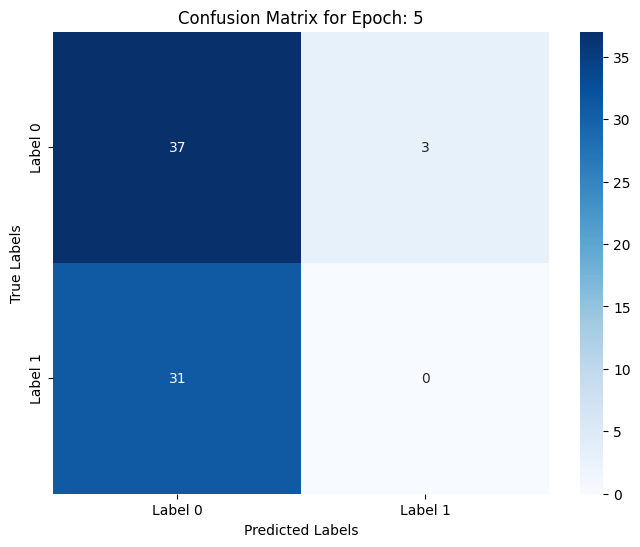

Epoch 6, Average Training Loss: 0.6921284854412079
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


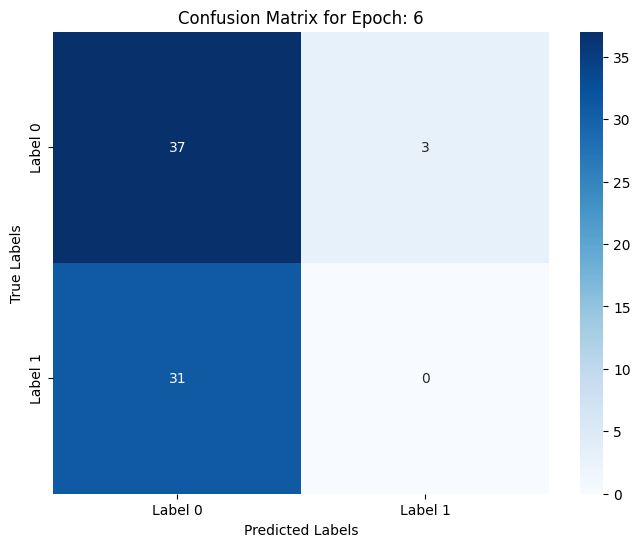

Epoch 7, Average Training Loss: 0.6919237479567528
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


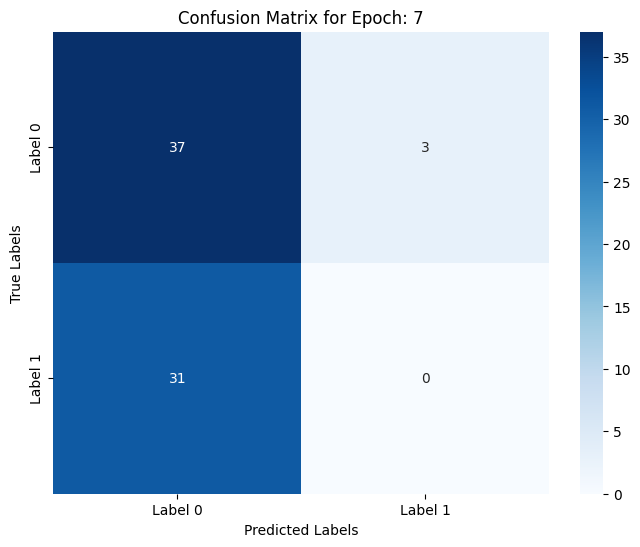

Epoch 8, Average Training Loss: 0.7000031426548958
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


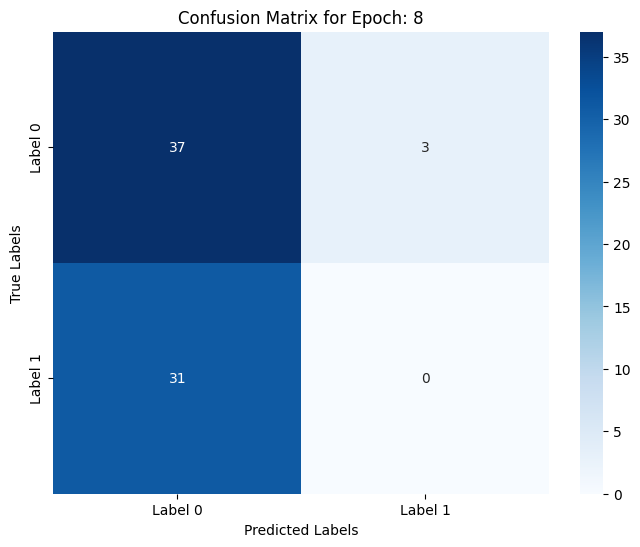

Epoch 9, Average Training Loss: 0.6925301492214203
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


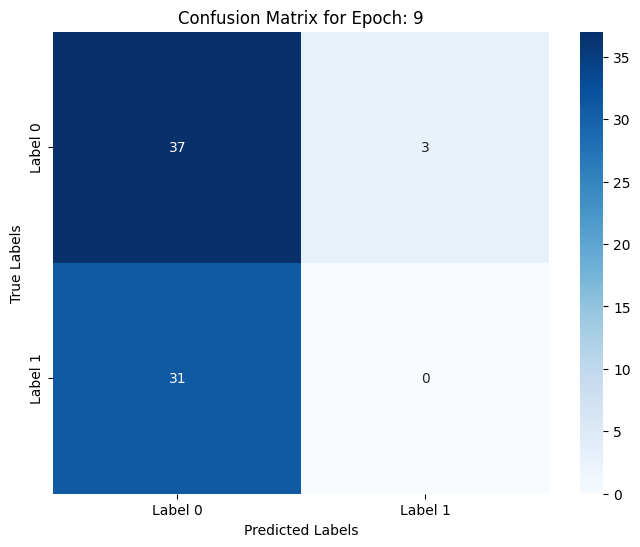

Epoch 10, Average Training Loss: 0.6928656205534935
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


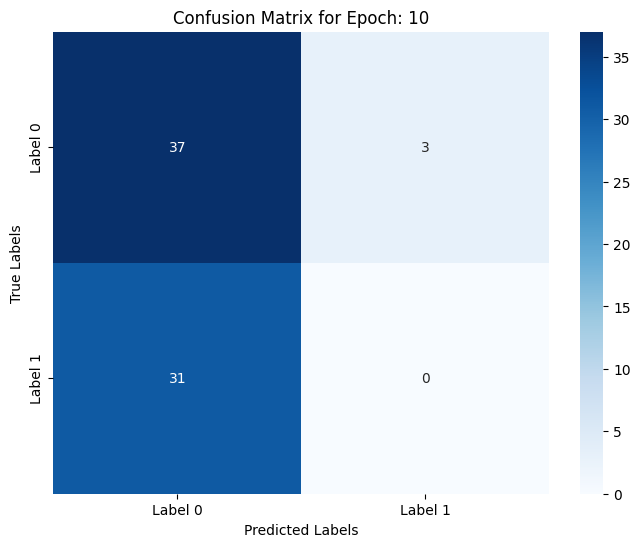

Epoch 11, Average Training Loss: 0.6958666712045669
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


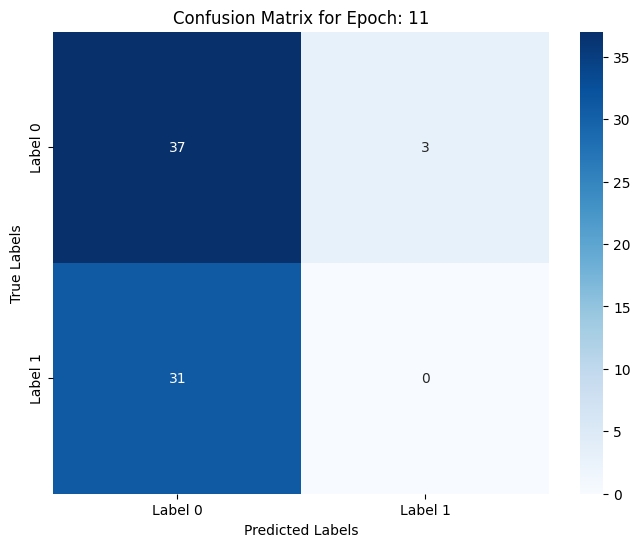

Epoch 12, Average Training Loss: 0.6914937049150467
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


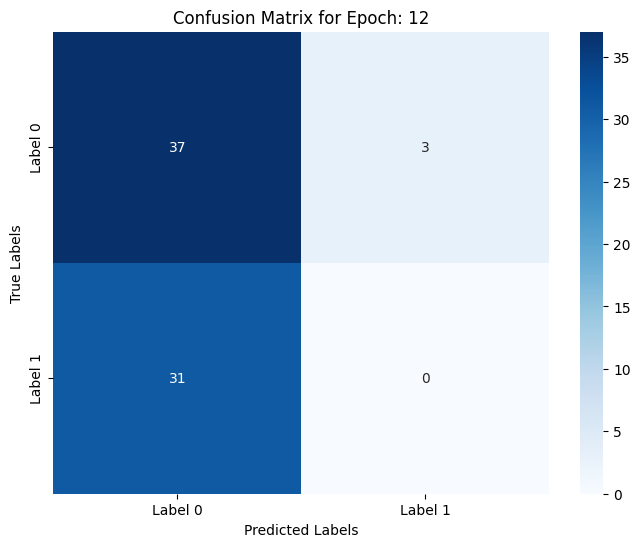

Epoch 13, Average Training Loss: 0.6925080016255378
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


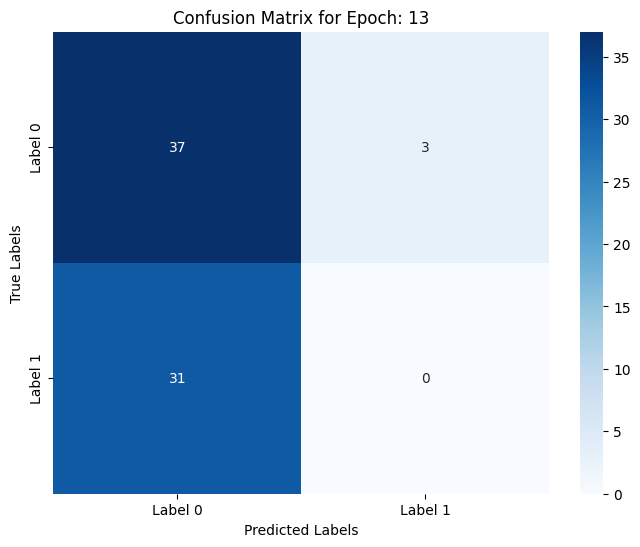

Epoch 14, Average Training Loss: 0.6958585232496262
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


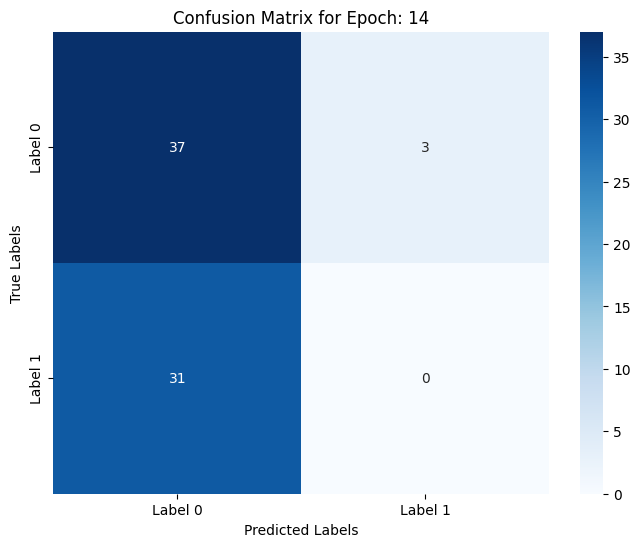

Epoch 15, Average Training Loss: 0.6946991175413132
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


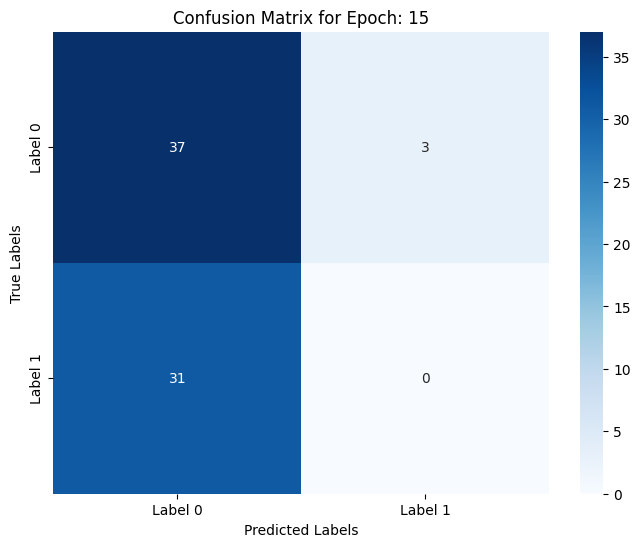

Epoch 16, Average Training Loss: 0.6920367240905761
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


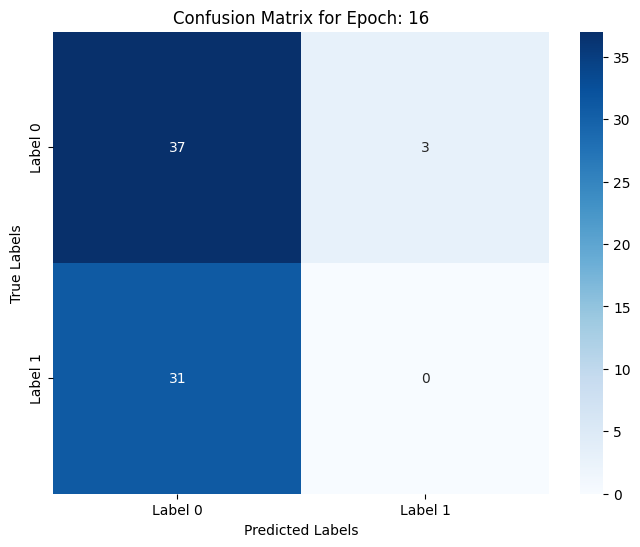

Epoch 17, Average Training Loss: 0.6886743485927582
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


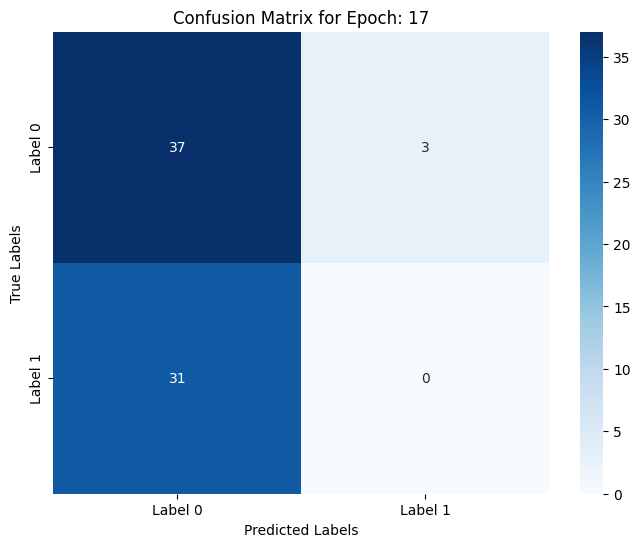

Epoch 18, Average Training Loss: 0.6932617053389549
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


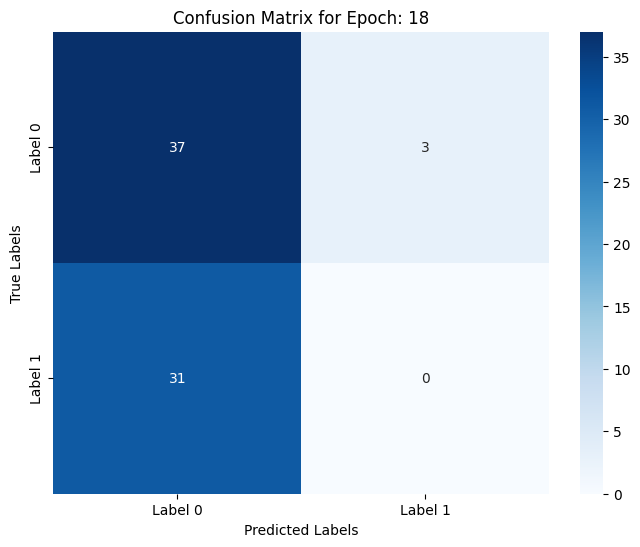

Epoch 19, Average Training Loss: 0.6934482619166374
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


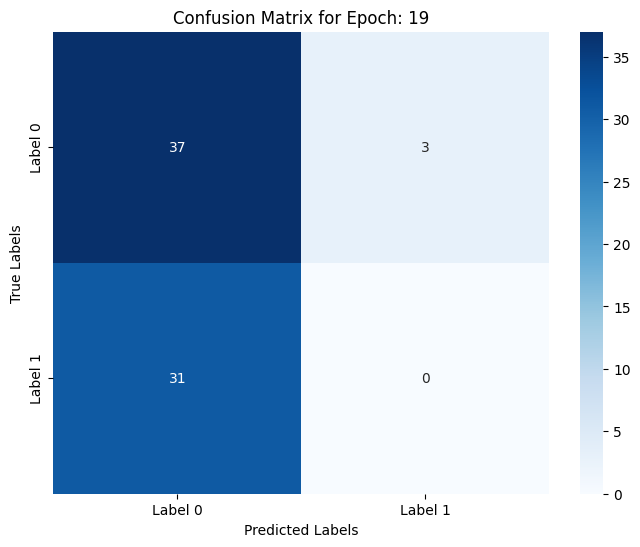

Epoch 20, Average Training Loss: 0.694986255466938
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


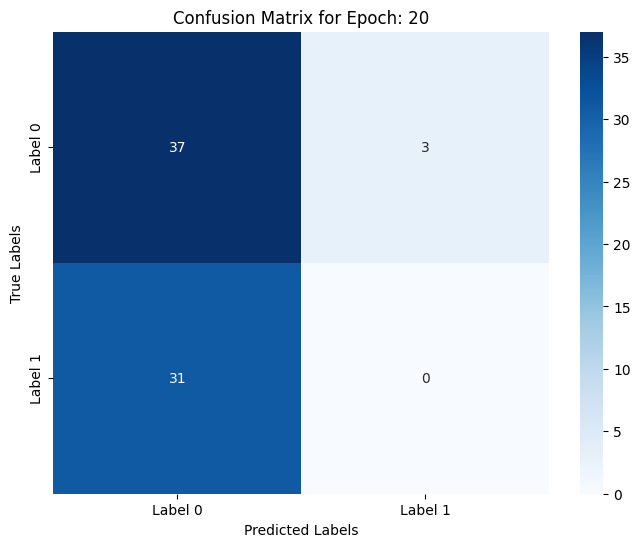

Epoch 21, Average Training Loss: 0.6970969989895821
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


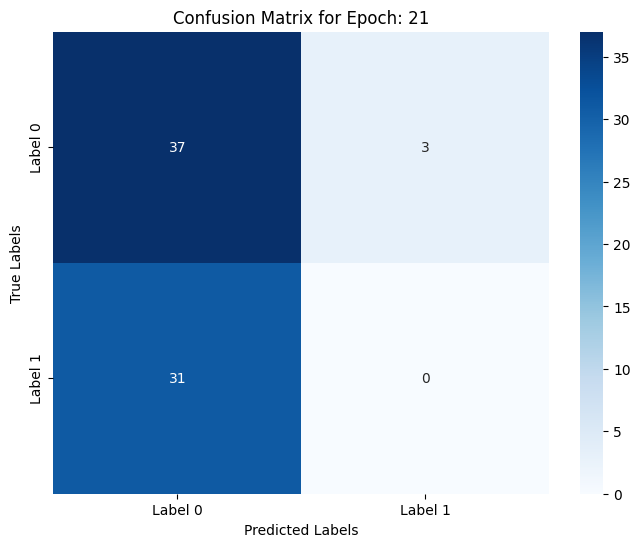

Epoch 22, Average Training Loss: 0.6888697743415833
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


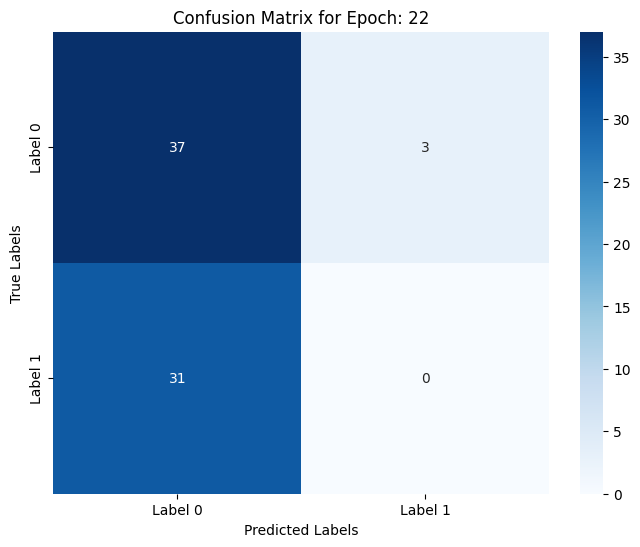

Epoch 23, Average Training Loss: 0.6946030989289284
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


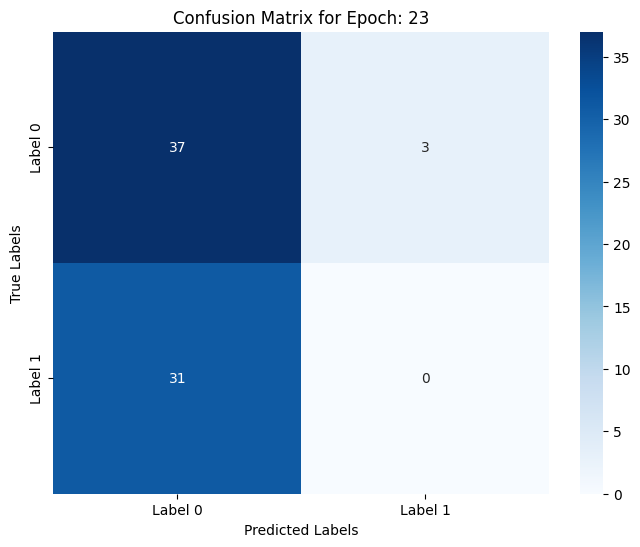

Epoch 24, Average Training Loss: 0.699191065132618
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


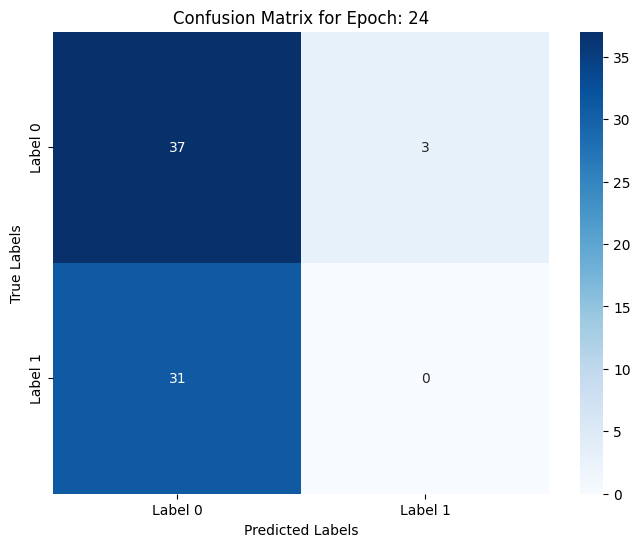

Epoch 25, Average Training Loss: 0.6952532455325127
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


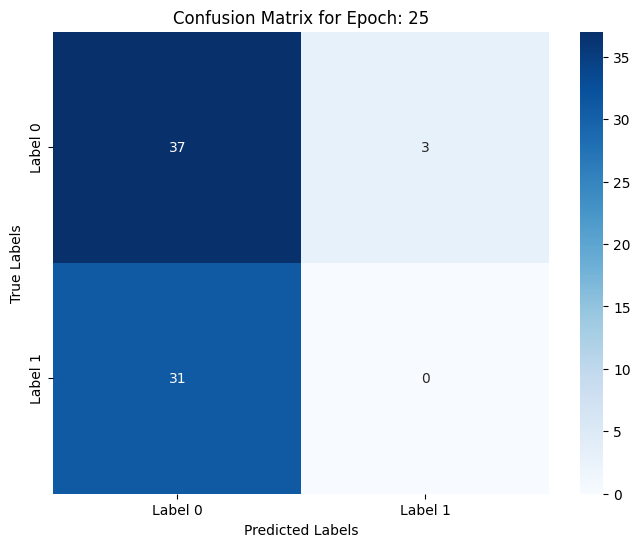

Epoch 26, Average Training Loss: 0.697973670065403
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


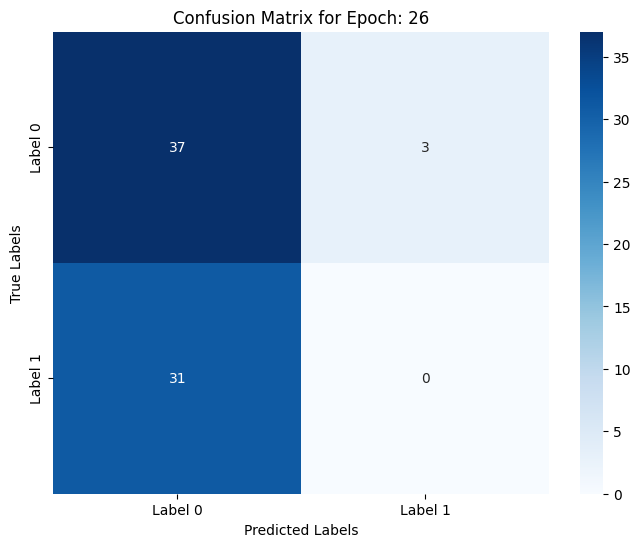

Epoch 27, Average Training Loss: 0.6977965101599694
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


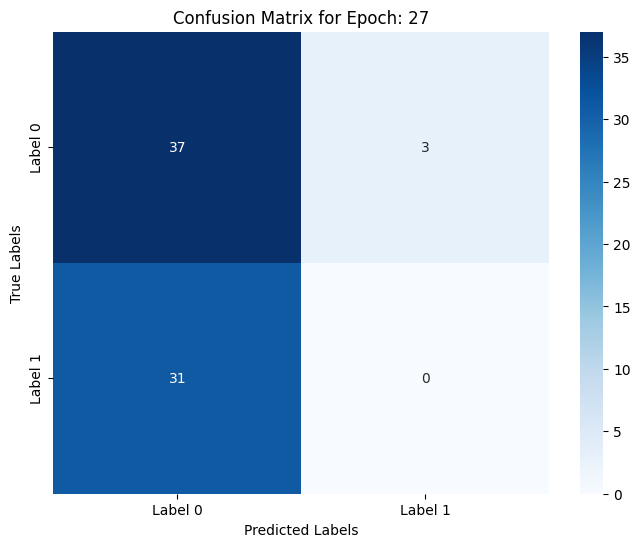

Epoch 28, Average Training Loss: 0.6971853241324425
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


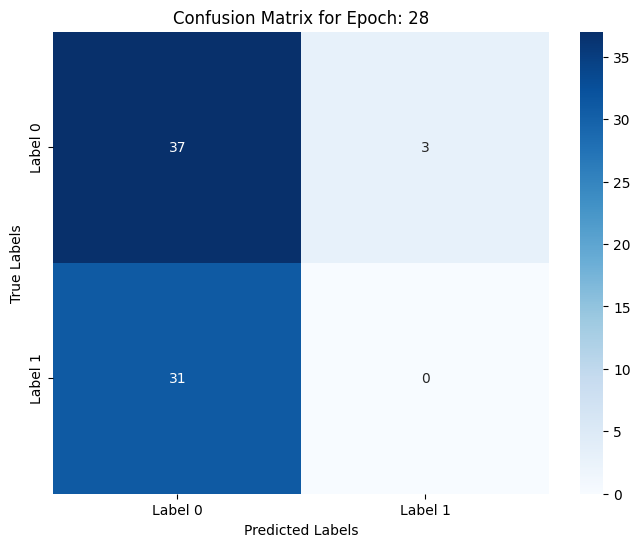

Epoch 29, Average Training Loss: 0.6919640645384788
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


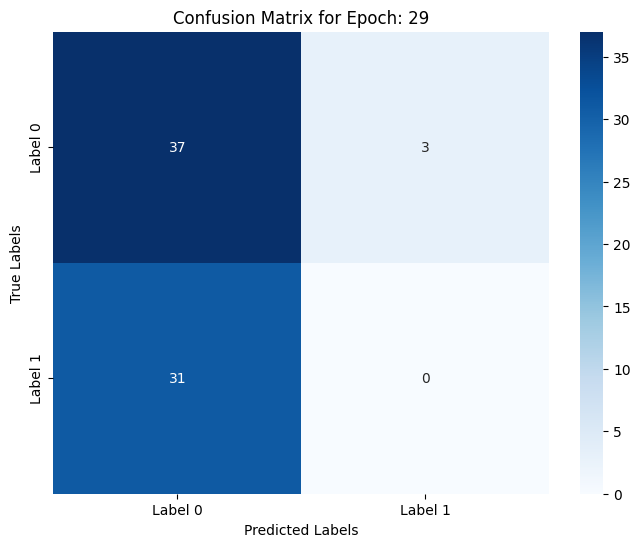

Epoch 30, Average Training Loss: 0.6944482177495956
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


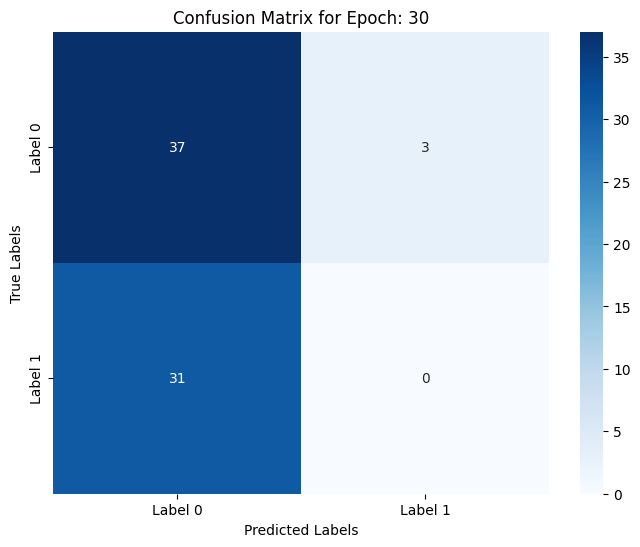

Epoch 31, Average Training Loss: 0.6963134855031967
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


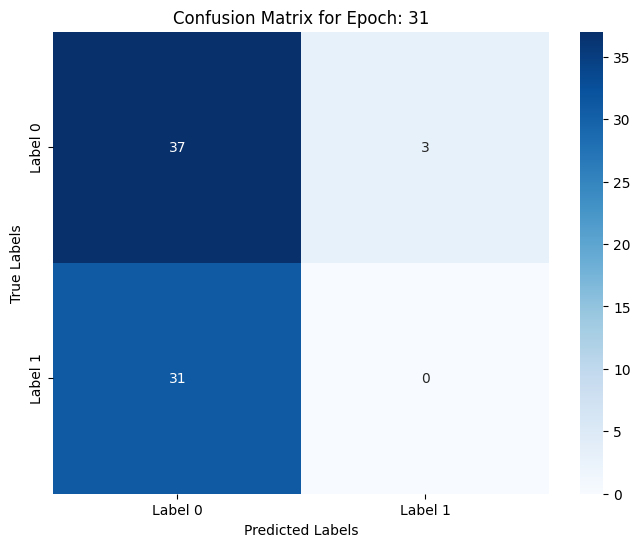

Epoch 32, Average Training Loss: 0.692409411072731
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


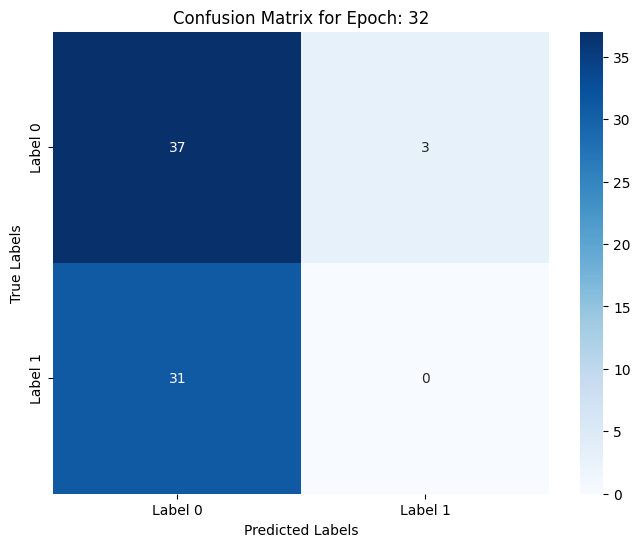

Epoch 33, Average Training Loss: 0.6913578659296036
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


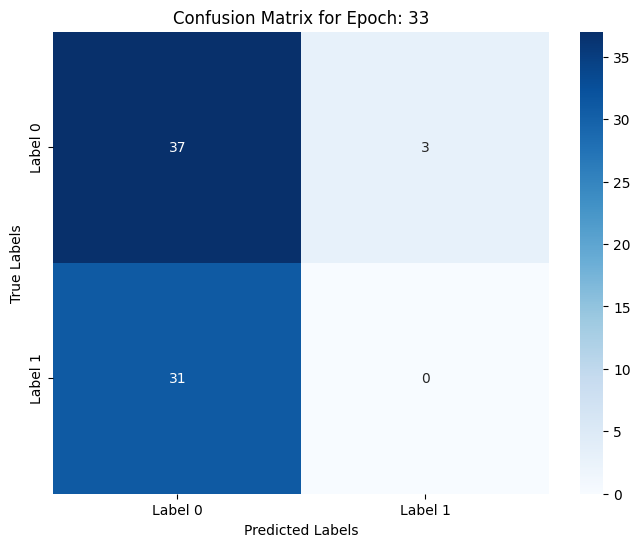

Epoch 34, Average Training Loss: 0.6948309376835823
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


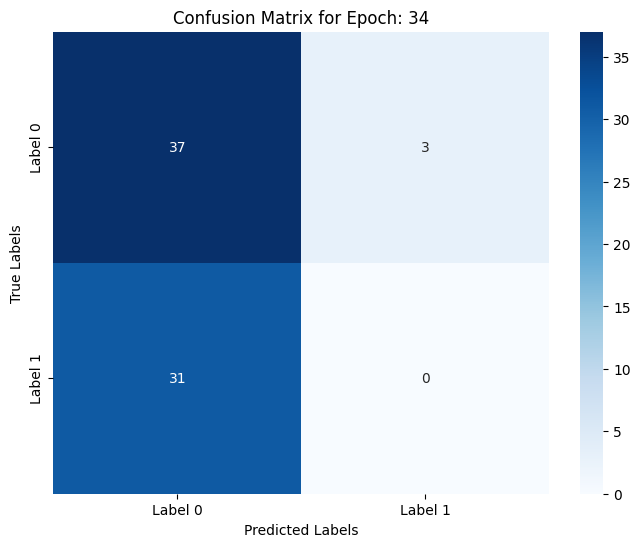

Epoch 35, Average Training Loss: 0.6925130382180213
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


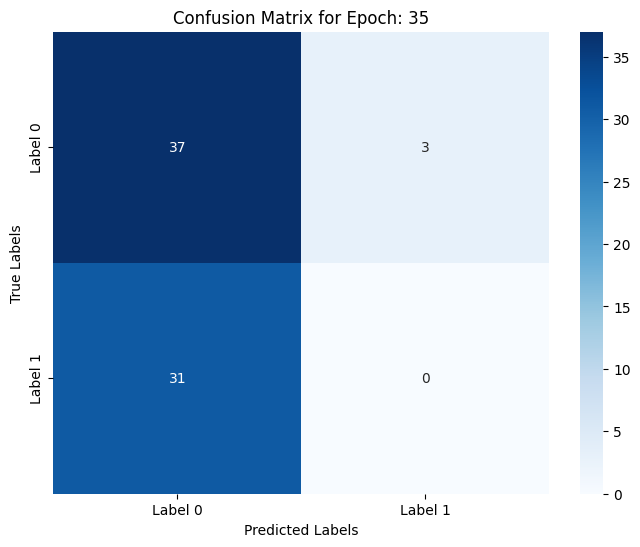

Epoch 36, Average Training Loss: 0.6932330891489983
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


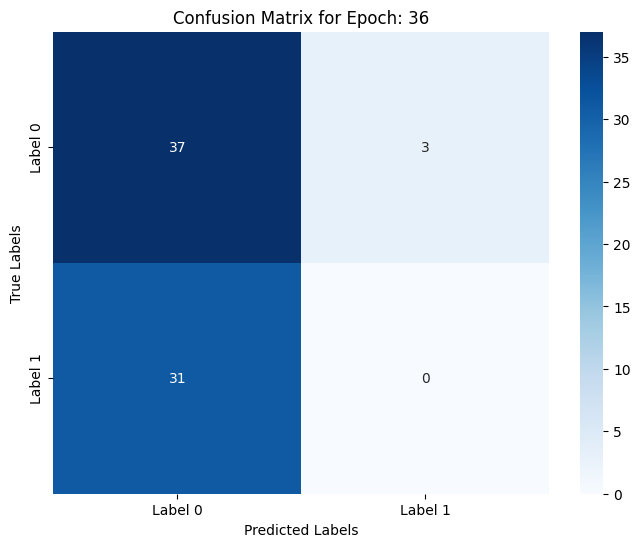

Epoch 37, Average Training Loss: 0.6916802063584327
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


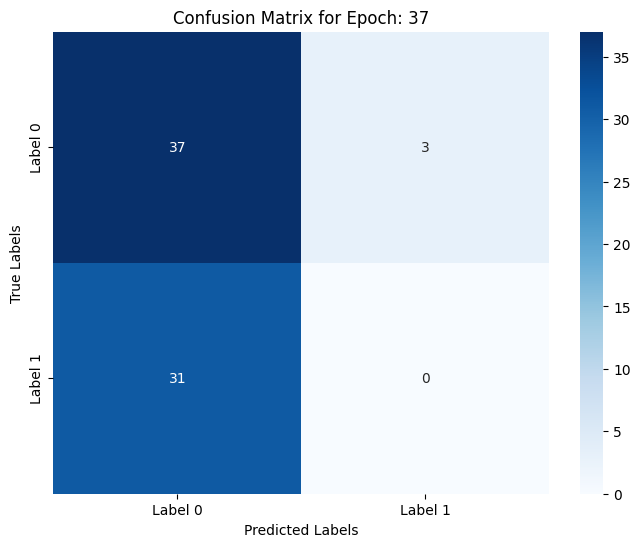

Epoch 38, Average Training Loss: 0.6957316651940346
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


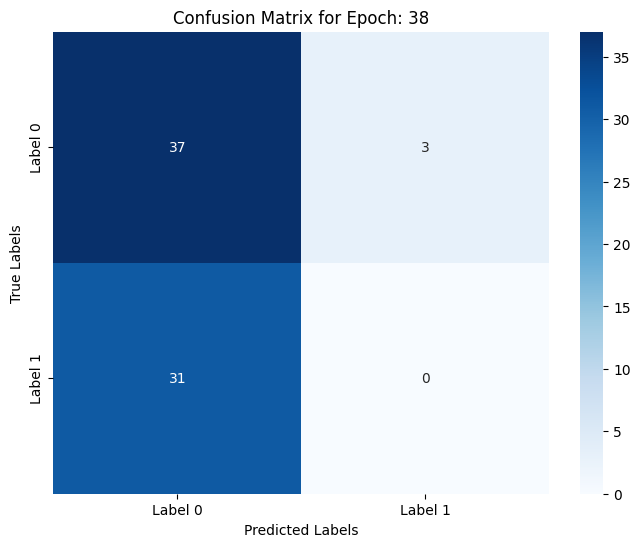

Epoch 39, Average Training Loss: 0.6966848045587539
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


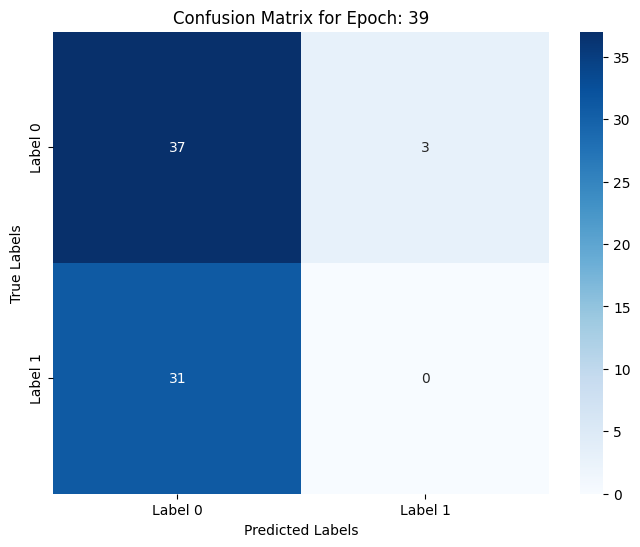

Epoch 40, Average Training Loss: 0.6972317799925805
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


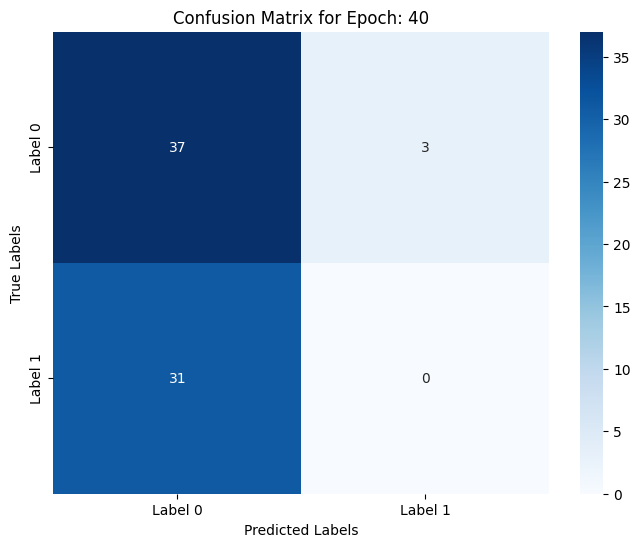

Epoch 41, Average Training Loss: 0.6937187537550926
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


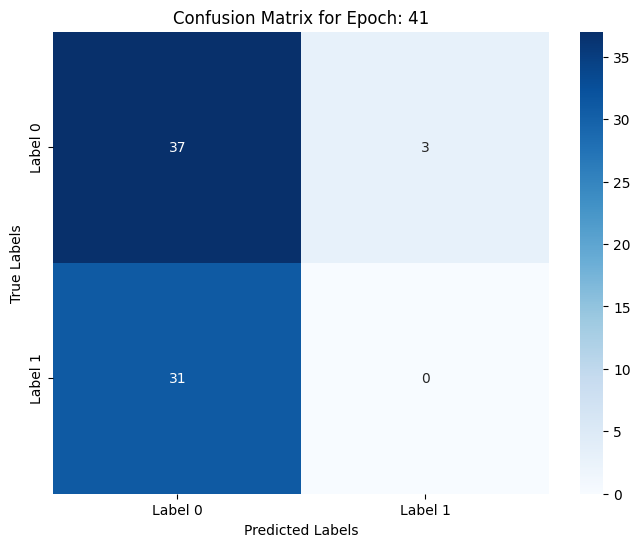

Epoch 42, Average Training Loss: 0.6934926778078079
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


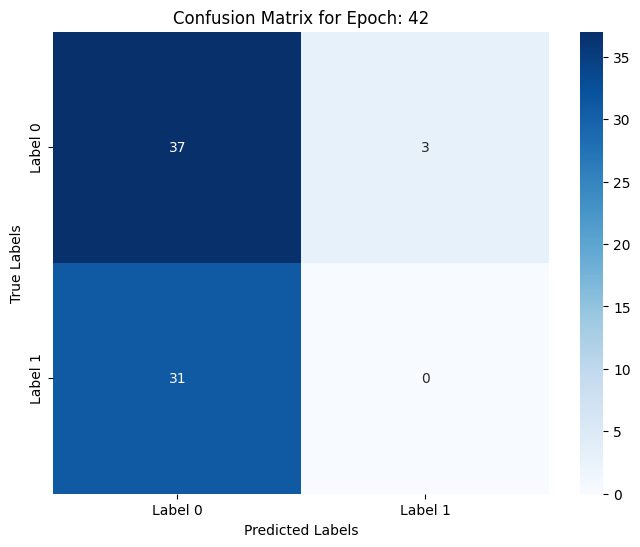

Epoch 43, Average Training Loss: 0.6922175854444503
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


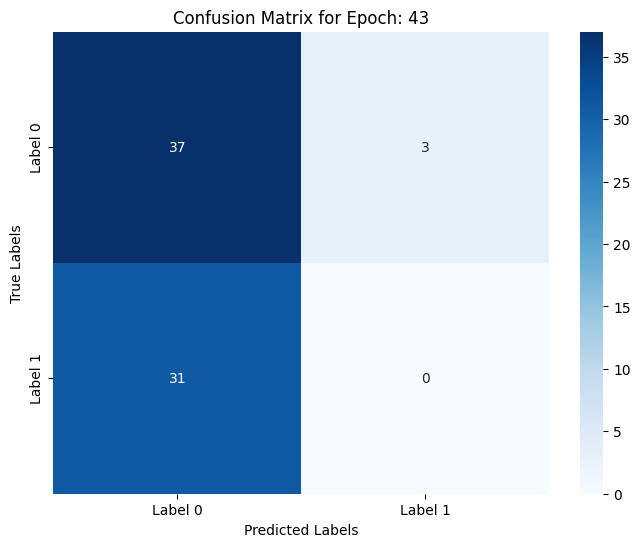

Epoch 44, Average Training Loss: 0.6928465351462364
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


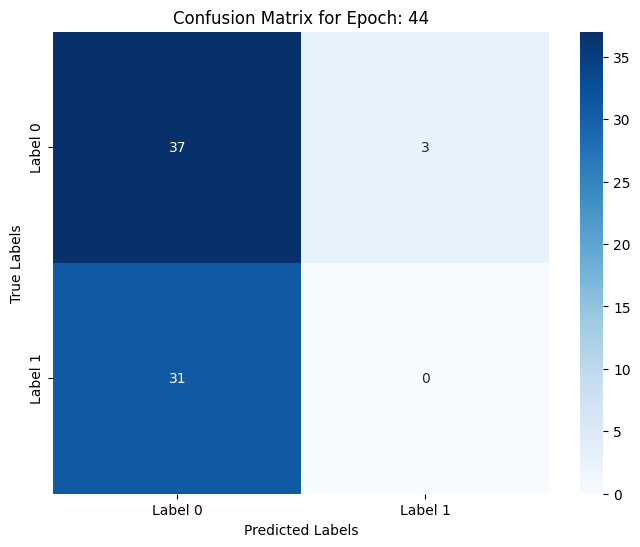

Epoch 45, Average Training Loss: 0.6930821239948273
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


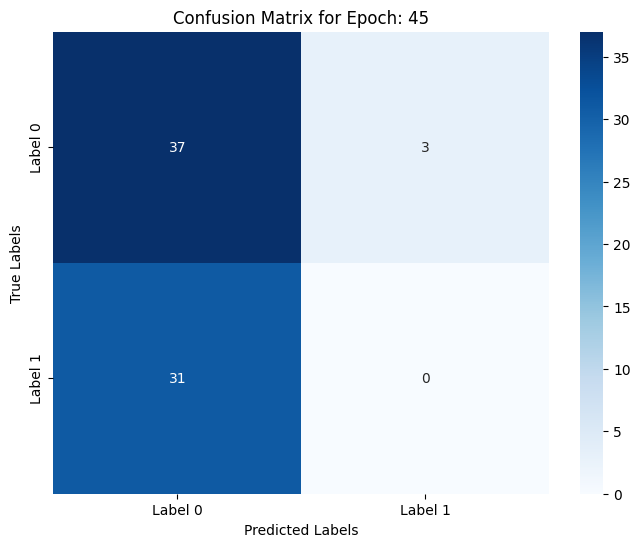

Epoch 46, Average Training Loss: 0.6951507806777955
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


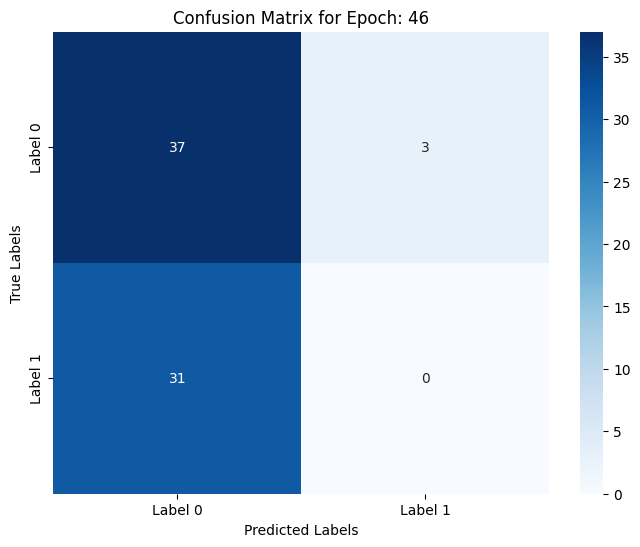

Epoch 47, Average Training Loss: 0.6936751276254653
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


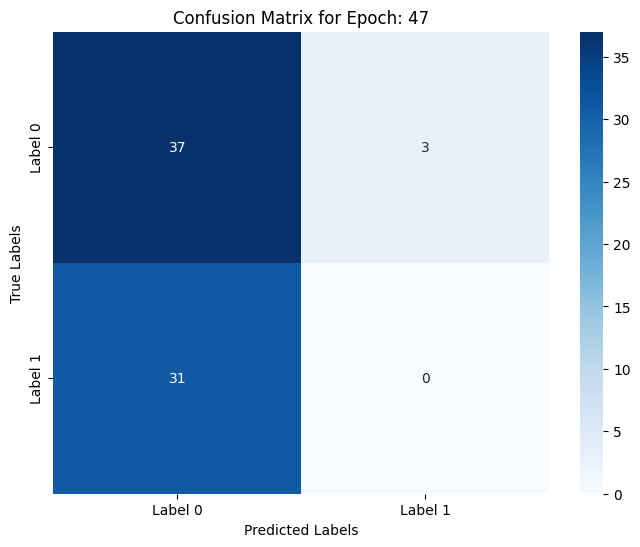

Epoch 48, Average Training Loss: 0.6949386551976204
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


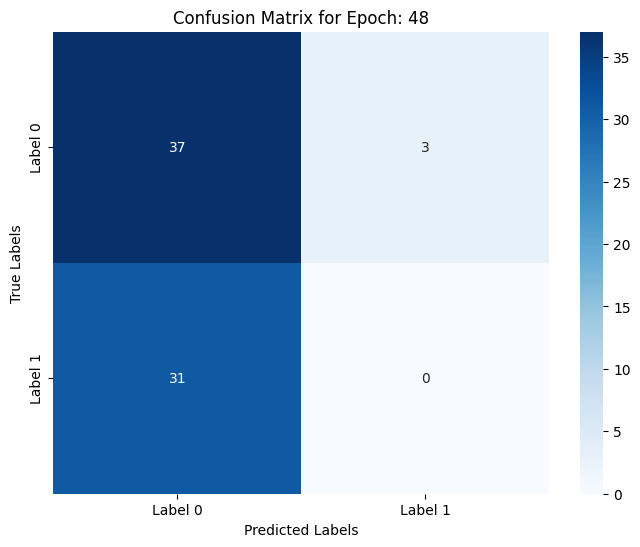

Epoch 49, Average Training Loss: 0.6925750344991684
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


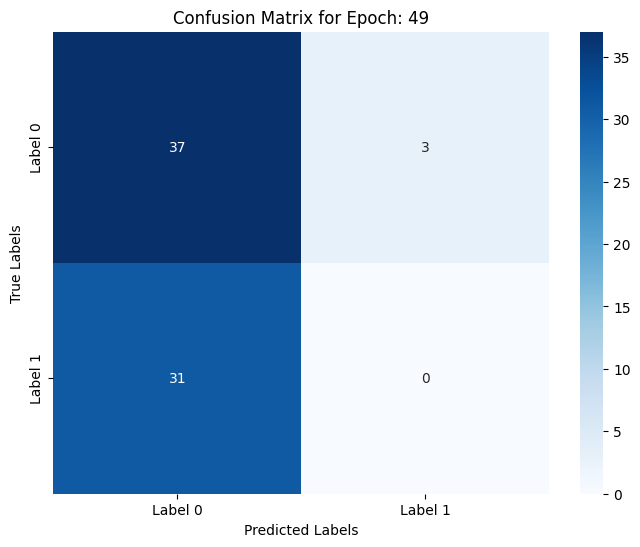

Epoch 50, Average Training Loss: 0.6979786276817321
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


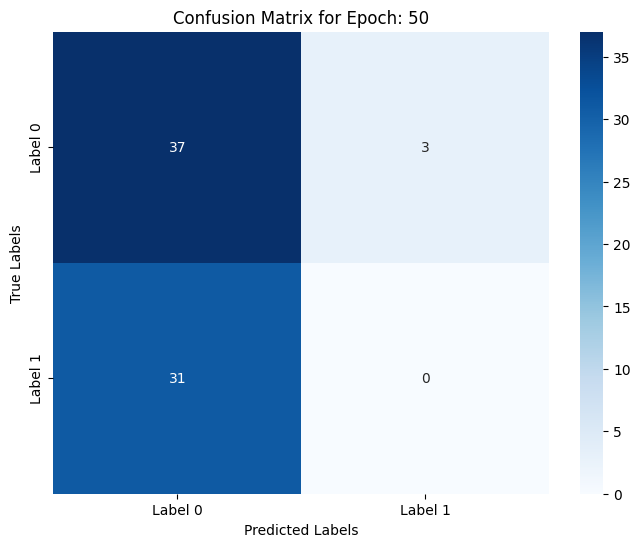

Epoch 51, Average Training Loss: 0.6958136573433876
Validation Accuracy: 0.5267857142857142
Validation F1 Score: 0.38601982263954093


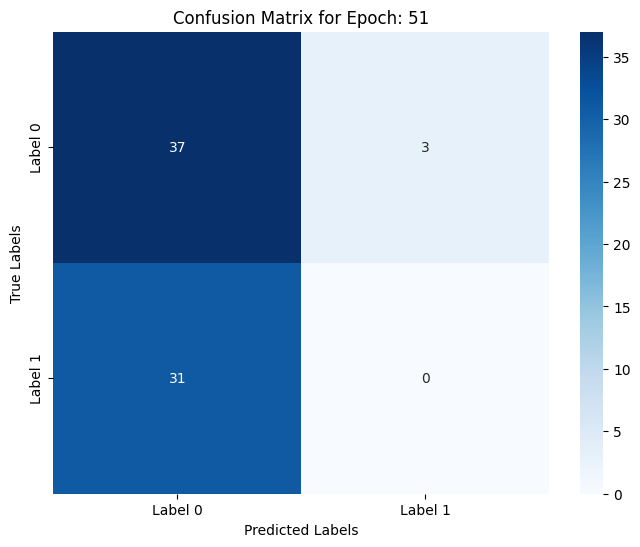

KeyboardInterrupt: 

In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Lists to store performance metrics for plotting
train_loss_set = []
accuracy_set = []
f1_set = []

# Training loop
for epoch in range(100):  # Training for 5 epochs
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_set.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []

    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)
        tmp_eval_accuracy = accuracy_score(np.argmax(logits, axis=1), label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    # Calculate overall metrics for the epoch
    epoch_accuracy = eval_accuracy / nb_eval_steps
    accuracy_set.append(epoch_accuracy)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_set.append(f1)
    print(f"Validation Accuracy: {epoch_accuracy}")
    print(f"Validation F1 Score: {f1}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Label 0', 'Label 1'], yticklabels=['Label 0', 'Label 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Epoch: {}'.format(epoch+1))
    plt.show()
